In [62]:
import local_models.local_models
import local_models.algorithms
import local_models.utils
import local_models.linear_projections
import local_models.loggin
import local_models.TLS_models
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cluster
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import sklearn.decomposition
import logging
import ml_battery.log
import time
import os
import pandas as pd
import scipy.fftpack
import gc



logger = logging.getLogger(__name__)

#reload(local_models.local_models)
#reload(lm)
#reload(local_models.loggin)
#reload(local_models.TLS_models)
np.warnings.filterwarnings('ignore')

In [63]:
def clear(fig, axs):
    for ax in axs:
        ax.clear()
    fig.clear()
    plt.close(fig)
    plt.close("all")

In [64]:
def adjust_ax_labels(axs):
    try:
        axs_iterator = iter(axs)
    except TypeError as te:
        axs_iterator = iter([axs])
    for ax in axs_iterator:
        ax.axis("off")
    ax.axis("on")
    ax.get_yaxis().set_visible(False)
    ax.set_frame_on(False)        

In [65]:
HZ = 250

In [66]:
mpl.rcParams['figure.figsize'] = [16.0, 8.0]
mpl.rcParams['font.size'] = int(mpl.rcParams['figure.figsize'][1]*3)

In [67]:
project_dir = "../data/todd_eeg"
os.makedirs(project_dir, exist_ok=1)

In [68]:
data_dir = "/disk2/home/brown/eeg/Phasespace/Phasespace/data/eeg-text"

In [69]:
data_info = pd.read_csv(os.path.join(data_dir, "fileinformation.csv"), skiprows=1).iloc[:,2:]

In [70]:
def spectrum(sig, d):
    f = scipy.fftpack.rfftfreq(sig.size, d=d)
    y = scipy.fftpack.rfft(sig)
    return f, y
#a computationally convenient approximation to the beta... sig on [0,1]
def kumaraswamy(sig,a=1.,b=1.):
    return a*b*sig**(a-1)*(1-sig**a)**(b-1)

In [71]:
WHICH_FILE = 0

In [72]:
data_file = data_info.iloc[WHICH_FILE,0]

In [73]:
data_epipoint = data_info.iloc[WHICH_FILE,4]

In [74]:
data_epipoint

3510000

In [75]:
dat = np.loadtxt(os.path.join(data_dir, data_file))

In [76]:
dat[:1000]

array([[ 205.,  191.,  150., ...,  394.,  351.,  391.],
       [ 213.,  185.,  140., ...,  195.,  263.,  218.],
       [ 193.,  156.,  125., ..., -123.,  -43., -119.],
       ...,
       [  88.,  185.,   70., ...,  317.,  284.,  328.],
       [  96.,  194.,   54., ...,  112.,   34.,  128.],
       [  77.,  168.,   22., ..., -149., -216., -182.]])

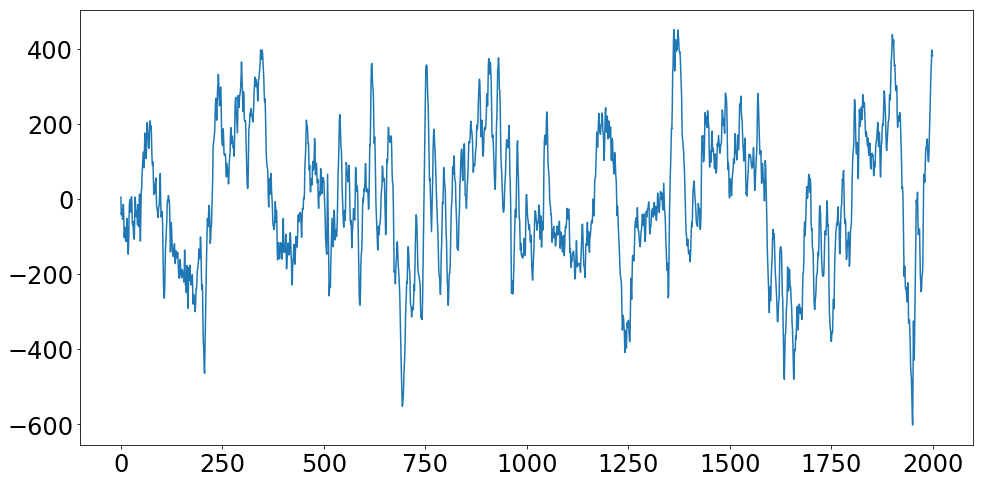

In [77]:
plt.plot(dat[data_epipoint-int(10e2):data_epipoint+int(10e2):,0])

In [78]:
f, y = spectrum(dat[:,0], 1/HZ)

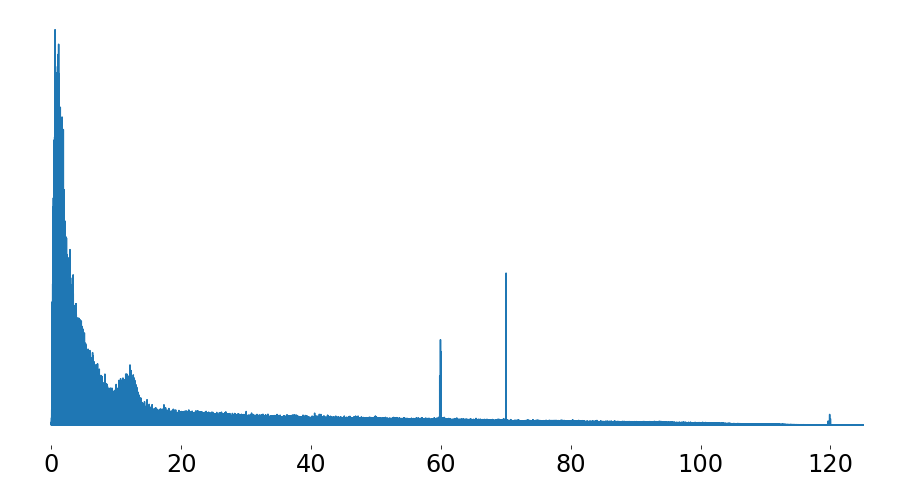

In [79]:
y_a = np.abs(y)/len(dat)*2 # Scale accordingly
fig, axs = plt.subplots(1, sharex=True, gridspec_kw={'hspace': 0})
adjust_ax_labels([axs]) 
axs.plot(f, y_a)
plt.savefig(os.path.join(project_dir, "raw_fft_eeg{}.png".format(data_file)))

In [80]:
f.shape

(3963799,)

In [81]:
y_filtered = np.copy(y)
y_filtered[np.max(np.nonzero(f<30)):] = 0
y_filtered[np.max(np.nonzero(f>0.05)):] = 0

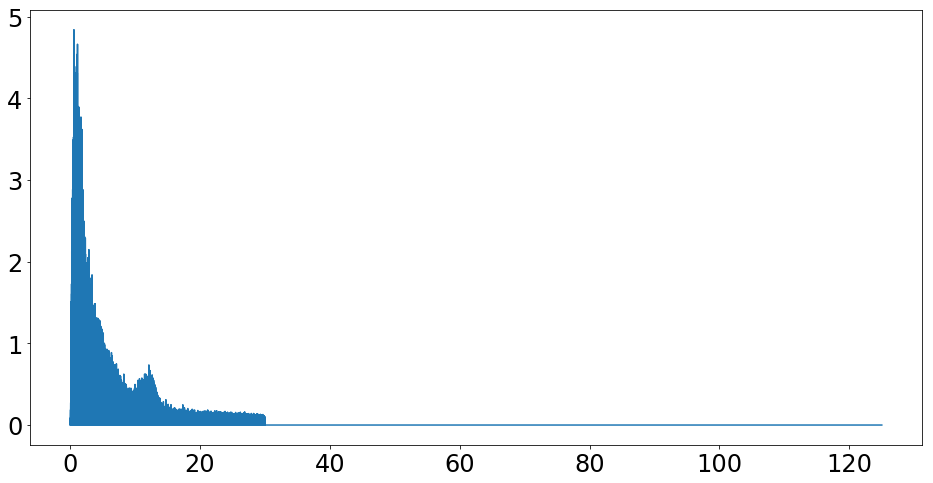

In [82]:
plt.plot(f, np.abs(y_filtered)/len(dat)*2)

In [83]:
max_f = np.max(f)

In [84]:
a = 1.2
b = 10.
kumaraswamy_filter = kumaraswamy(f/max_f,a,b)

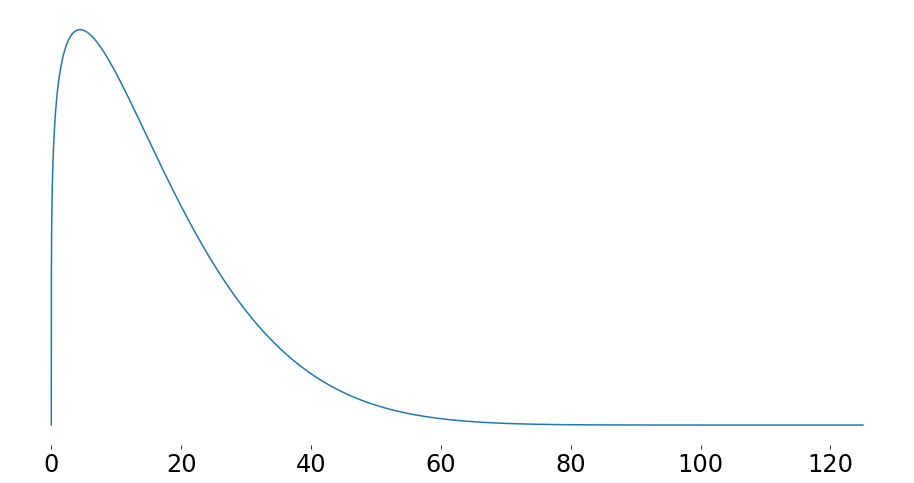

In [85]:
fig, axs = plt.subplots(1, sharex=True, gridspec_kw={'hspace': 0})
adjust_ax_labels([axs]) 
axs.plot(f, kumaraswamy_filter)
plt.savefig(os.path.join(project_dir, "kumaraswamy_filter_a{:05.02f}_b{:05.02f}.png".format(a,b)))

In [86]:
y_filtered_kumaraswamy = np.copy(y)
y_filtered_kumaraswamy *= kumaraswamy_filter
y_filtered_kumaraswamy /= np.max(kumaraswamy_filter)

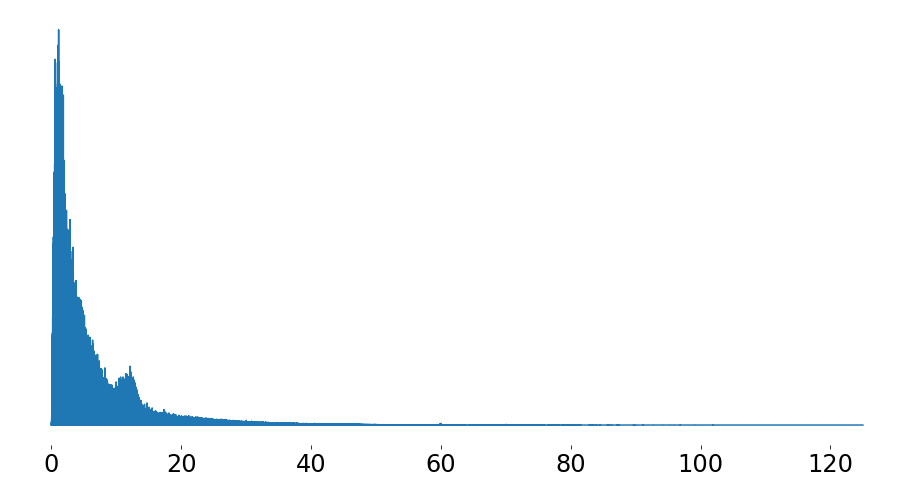

In [87]:
fig, axs = plt.subplots(1, sharex=True, gridspec_kw={'hspace': 0})
adjust_ax_labels([axs]) 
axs.plot(f, np.abs(y_filtered_kumaraswamy)/len(dat)*2)
plt.savefig(os.path.join(project_dir, "kumaraswamy_filtered_fft_eeg{}_a{:05.02f}_b{:05.02f}.png".format(data_file, a, b)))

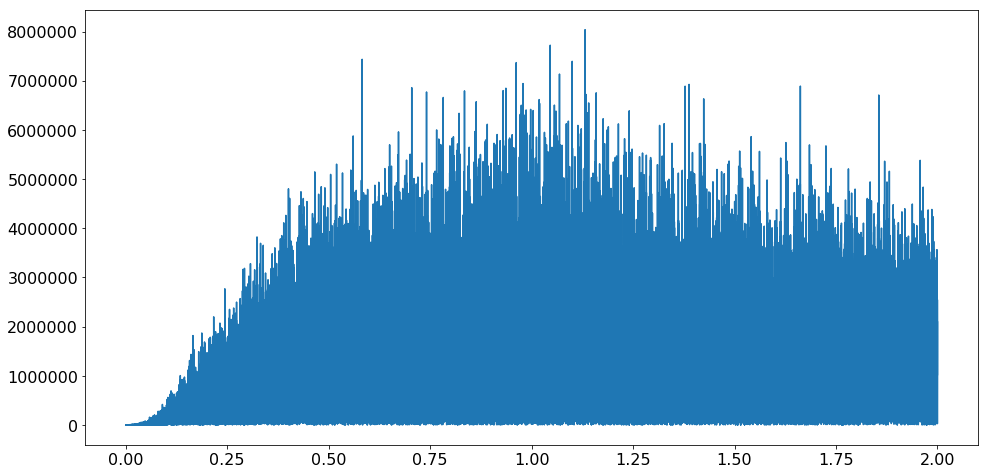

In [30]:
plt.plot(f[f<2],np.abs(y_filtered_kumaraswamy[f<2]))

In [33]:
sig_filtered = scipy.fftpack.irfft(y_filtered)

In [34]:
sig_kumaraswamy_filtered = scipy.fftpack.irfft(y_filtered_kumaraswamy)

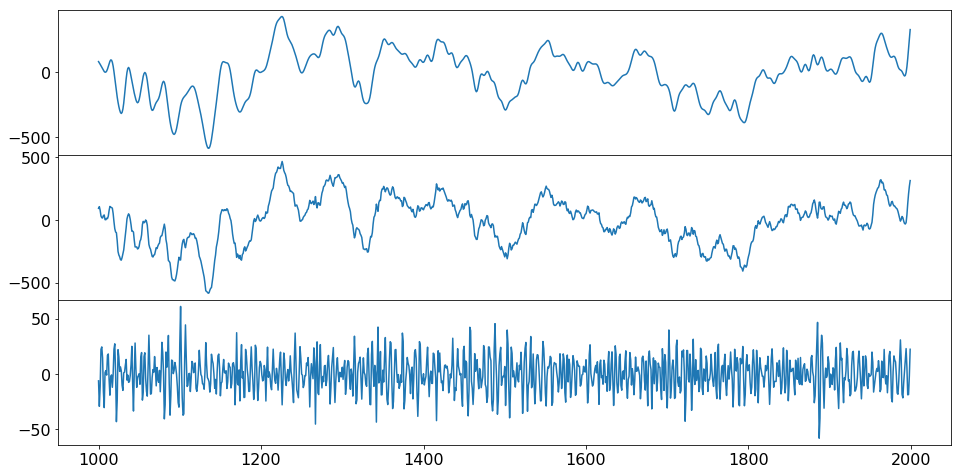

In [35]:
rng=(1000,2000)
X=np.arange(*rng)
fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
axs[0].plot(X,sig_filtered[slice(*rng)])
axs[1].plot(X,dat[slice(*rng),0])
axs[2].plot(X,sig_filtered[slice(*rng)]-dat[slice(*rng),0])

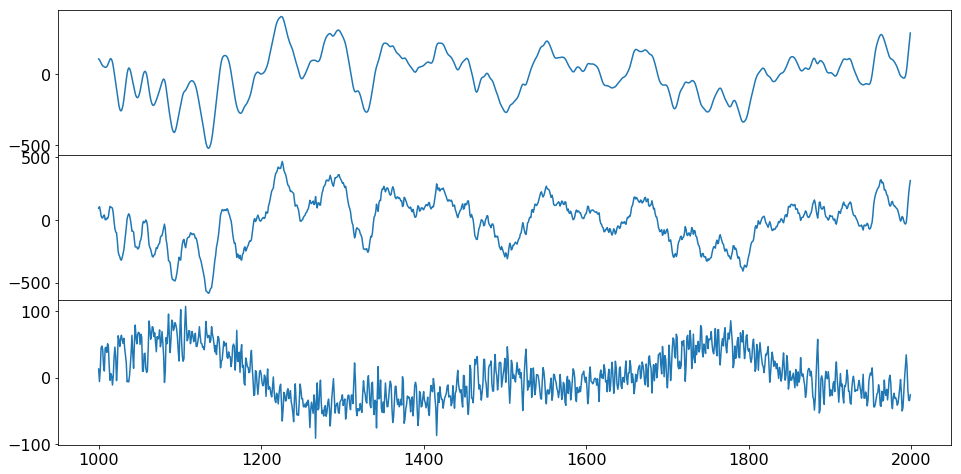

In [36]:
rng=(1000,2000)
X=np.arange(*rng)
fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
axs[0].plot(X,sig_kumaraswamy_filtered[slice(*rng)])
axs[1].plot(X,dat[slice(*rng),0])
axs[2].plot(X,sig_kumaraswamy_filtered[slice(*rng)]-dat[slice(*rng),0])
plt.savefig(os.path.join(project_dir, "kumaraswamy_filtered_eeg{}_a{:05.02f}_b{:05.02f}_rng{}.png".format(data_file,a,b,str(rng))))

In [37]:
signal_v_filtered_signal_diff = sig_filtered-dat[:,0]
print(np.max(signal_v_filtered_signal_diff), np.min(signal_v_filtered_signal_diff))
print(np.argmax(signal_v_filtered_signal_diff), np.argmin(signal_v_filtered_signal_diff))
biggest_diff_pt = np.argmax(signal_v_filtered_signal_diff)

3098.710079203749 -4105.1105896767795
2770897 2770895


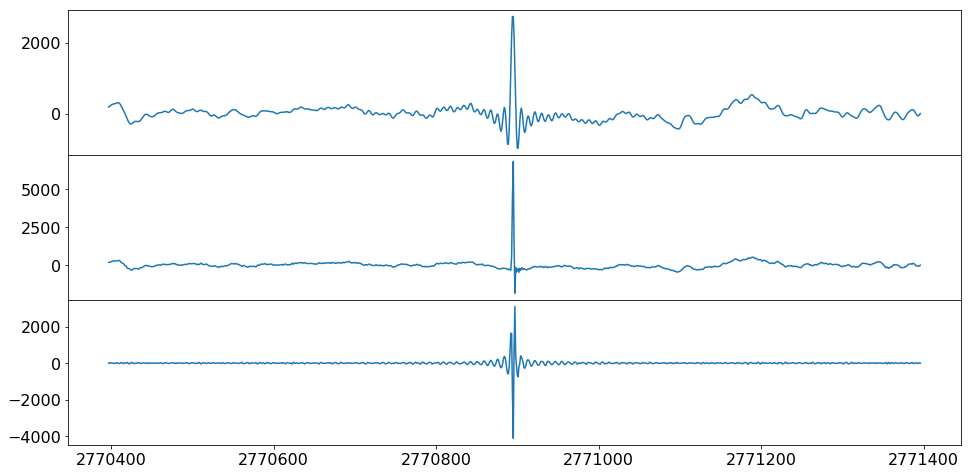

In [38]:
rng = (biggest_diff_pt-500,biggest_diff_pt+500)
X=np.arange(*rng)
fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
axs[0].plot(X,sig_filtered[slice(*rng)])
axs[1].plot(X,dat[slice(*rng),0])
axs[2].plot(X,sig_filtered[slice(*rng)]-dat[slice(*rng),0])

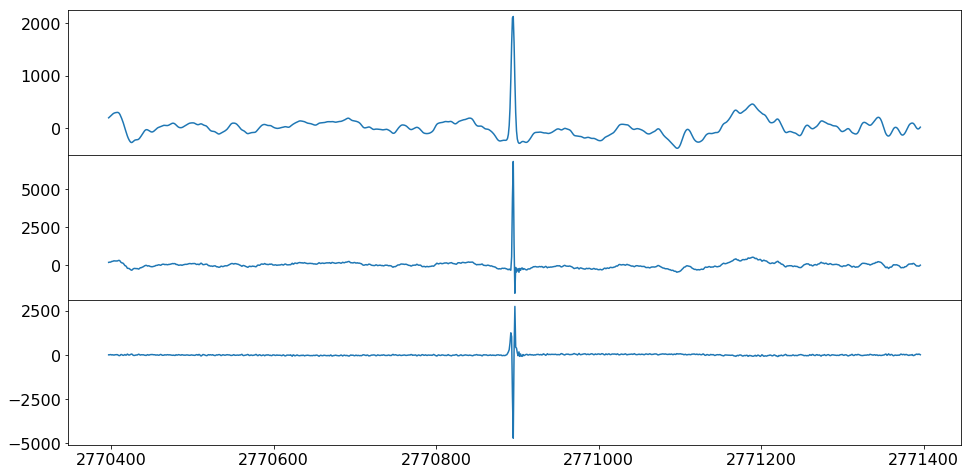

In [39]:
rng = (biggest_diff_pt-500,biggest_diff_pt+500)
X=np.arange(*rng)
fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
axs[0].plot(X,sig_kumaraswamy_filtered[slice(*rng)])
axs[1].plot(X,dat[slice(*rng),0])
axs[2].plot(X,sig_kumaraswamy_filtered[slice(*rng)]-dat[slice(*rng),0])
plt.savefig(os.path.join(project_dir, "kumaraswamy_filtered_biggest_diff_eeg{}_a{:05.02f}_b{:05.02f}_rng{}.png".format(data_file,a,b,str(rng))))

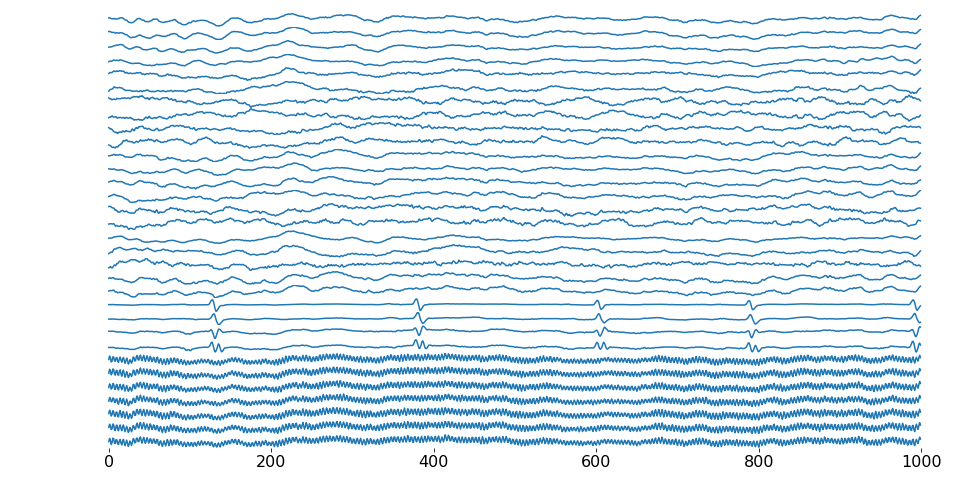

In [40]:
fig, axs = plt.subplots(dat.shape[1], sharex=True, gridspec_kw={'hspace': 0})
for var in range(dat.shape[1]):
    axs[var].plot(dat[1000:2000,var])
    if var != dat.shape[1]-1:
        axs[var].axis("off")
    else:
        axs[var].get_yaxis().set_visible(False)
        axs[var].set_frame_on(False)

In [15]:
def plt_and_save(data_dir, data_file, data_epipoint, fname_format, l, height, width, HZ=250):
    import numpy as np
    import matplotlib.pyplot as plt
    import scipy.fftpack
    import matplotlib as mpl
    mpl.rcParams['font.size'] = int(height)
    dat = np.loadtxt(os.path.join(data_dir, data_file))
    fig, axs = plt.subplots(dat.shape[1], 
        sharex=True, gridspec_kw={'hspace': 0}, figsize=(width, height))
    for var in range(dat.shape[1]):
        rng = (max(0,data_epipoint-l), min(dat.shape[0], data_epipoint+l))
        y = dat[slice(*rng),var]
        freq, power = spectrum(y, 1/HZ)
        max_freq = np.max(freq)
        kumaraswamy_filter = kumaraswamy(freq/max_freq,1.2,10.)
        power_filtered_kumaraswamy = power
        power_filtered_kumaraswamy *= kumaraswamy_filter
        power_filtered_kumaraswamy /= np.max(kumaraswamy_filter)
        y_filtered = scipy.fftpack.irfft(power_filtered_kumaraswamy)
        X = np.arange(*rng)
        axs[var].plot(X, y_filtered)
        axs[var].axvline(data_epipoint,c='r',lw=5)
        if var != dat.shape[1]-1:
            axs[var].axis("off")
        else:
            axs[var].set_xticks(np.arange(rng[0],rng[1],HZ))
            axs[var].set_xticklabels((np.arange(rng[0],rng[1],HZ)/HZ).astype(int)-int(data_epipoint/HZ))
            axs[var].get_yaxis().set_visible(False)
            axs[var].set_frame_on(False)
    plt.savefig(os.path.join(project_dir, fname_format.format(l, data_file)),bbox_inches="tight")
    clear(fig, axs)
    del dat
    del power_filtered_kumaraswamy
    del y_filtered
    del X
    del freq
    del power
    del y

In [16]:
from multiprocessing import Pool

In [17]:
l = 5000*10
height = 8.
width = 16.*l/5000
jerbs = []
epipoint_fname_format = "filtered_epipoint_l{:07d}_eeg_{}.png"
nonepipoint_fname_format = "filtered_nonepi_l{:07d}_eeg_{}.png"
for data_entry in range(data_info.shape[0]):
    data_file = data_info.iloc[data_entry,0]
    data_epipoint = data_info.iloc[data_entry,4]
    data_length = data_info.iloc[data_entry,1]
    if 0 < data_epipoint < data_length:
        jerbs.append((data_dir, data_file, data_epipoint, epipoint_fname_format, l, height, width))
        jerbs.append((data_dir, data_file, int(data_epipoint/2), nonepipoint_fname_format, l, height, width))

In [18]:
jerbs

[('/disk2/home/brown/eeg/Phasespace/Phasespace/data/eeg-text',
  'DAT.F00012',
  3510000,
  'filtered_epipoint_l{:07d}_eeg_{}.png',
  50000,
  8.0,
  160.0),
 ('/disk2/home/brown/eeg/Phasespace/Phasespace/data/eeg-text',
  'DAT.F00012',
  1755000,
  'filtered_nonepi_l{:07d}_eeg_{}.png',
  50000,
  8.0,
  160.0),
 ('/disk2/home/brown/eeg/Phasespace/Phasespace/data/eeg-text',
  'DAT.F00013',
  3180000,
  'filtered_epipoint_l{:07d}_eeg_{}.png',
  50000,
  8.0,
  160.0),
 ('/disk2/home/brown/eeg/Phasespace/Phasespace/data/eeg-text',
  'DAT.F00013',
  1590000,
  'filtered_nonepi_l{:07d}_eeg_{}.png',
  50000,
  8.0,
  160.0),
 ('/disk2/home/brown/eeg/Phasespace/Phasespace/data/eeg-text',
  'DAT.F00016',
  3990000,
  'filtered_epipoint_l{:07d}_eeg_{}.png',
  50000,
  8.0,
  160.0),
 ('/disk2/home/brown/eeg/Phasespace/Phasespace/data/eeg-text',
  'DAT.F00016',
  1995000,
  'filtered_nonepi_l{:07d}_eeg_{}.png',
  50000,
  8.0,
  160.0),
 ('/disk2/home/brown/eeg/Phasespace/Phasespace/data/eeg-te

In [19]:
def plt_and_save_starargs(args):
    return plt_and_save(*args)

In [20]:
p = Pool(16)
print(p.map(plt_and_save_starargs, jerbs))

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [ ]:
data_info.iloc[data_entry]

In [ ]:
dat.shape

In [ ]:
data_file

In [ ]:
dat[slice(*rng),var].shape

In [ ]:
slice(*rng)

In [99]:
dat.shape

(4126199, 32)